<a href="https://colab.research.google.com/github/cagatayeskin/Data-Fitting-with-ANNs/blob/main/Data_with_Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Fitting a Linear Model to Data with Outliers (Errors in both coordinates)***

## **General Solution**


We generate errors on data points using Cauchy distribution, and use the general solution given by the **York (1966)** to compare Artificial Neural Network results. We know that general solution can only give approximate results because it assumes normally distributed errors. To create a dataset, the model that we are going to use will be 

We start with providing the general solution proposed by **York (1966)**. To test the general solution, we first create a test data. After moving on to the Artificial Neural Network part, we use this data set again to compare two methods.

We use a linear model in below form to create data points. After creating $N_{test}$ number of data points on the line given by model, we sample set of $\sigma_{x_i}$ and $\sigma_{y_i}$ for each point. Using variances, we sample noise values, $δx_i$ and $δy_i$ for each point from Cauchy distribution. This way we create a test data and use it as an example to show predictions of two methods. Accuracy of the methods will be subject to further testing later in this notebook.

$$
    y = b_{true}x + a_{true}
$$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import cauchy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.7.0


## Create a test data and show it on a plot with York's general solution

In [ ]:
N_test = 76 # number of data points
sigma_X = np.random.uniform(0.02, 0.06, N_test) # sample x coordinate sigmas from uniform distribution
sigma_Y = np.random.uniform(0.15, 0.20, N_test) # sample y coordinate sigmas from uniform distribution

distribution = cauchy(scale = 0.15)

noise_X = np.multiply(distribution.rvs(size=N_test), sigma_X)
noise_Y = np.multiply(distribution.rvs(size=N_test), sigma_Y)
 
# True parameters of the model which will be used to generate data
a_true = 3.83
b_true = -1.67

X = np.linspace(0.1, 0.9, N_test) + noise_X # observed X points
Y = b_true*(X-noise_X) + a_true + noise_Y # observed Y points

### York's General solution

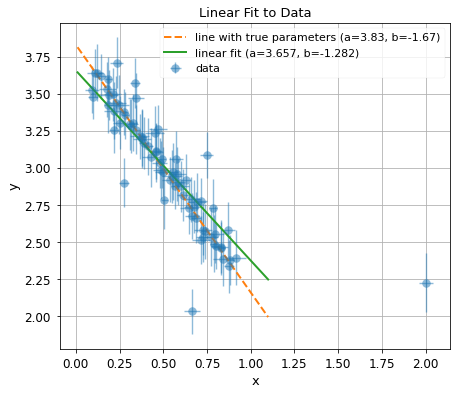

In [ ]:
# Create a figure
fig = plt.figure(figsize=(7, 6))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
#plt.plot(X, Y, 'o', label='data', ms=8.5, alpha=0.5)
plt.errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=8.5, alpha=0.5) # error bars show SD

# Plotting the line with true parameters
x_plot = np.linspace(0.01, 1.1, N_test)
y_true_plot = b_true*x_plot + a_true
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ')'))


# Function that calculates the parameters (using same notation with York)
def linear_fit(b_pred, iter): # start with a prediction of b and number of iterations
    for k in range(iter): 
        w_X = 1/np.power(sigma_X, 2) 
        w_Y = 1/np.power(sigma_Y, 2) 
        W = np.multiply(w_X, w_Y)/(b_pred**2*w_Y + w_X)
        X_bar = np.sum(np.multiply(W, X))/np.sum(W)
        Y_bar = np.sum(np.multiply(W, Y))/np.sum(W)
        U = X - X_bar
        V = Y - Y_bar
        alpha_numerator = 0
        alpha_denominator = 0
        beta_numerator = 0
        beta_denominator = 0
        gamma_numerator = 0
        gamma_denominator = 0
        for i in range(N_test):
            alpha_numerator = alpha_numerator + W[i]**2*U[i]*V[i]/w_X[i]
            alpha_denominator = alpha_denominator + W[i]**2*U[i]**2/w_X[i]
            beta_numerator = beta_numerator + (W[i]**2*V[i]**2/w_X[i]) - W[i]*U[i]**2
            beta_denominator = beta_denominator + W[i]**2*U[i]**2/w_X[i]
            gamma_numerator = gamma_numerator + W[i]*U[i]*V[i]
            gamma_denominator = gamma_denominator + W[i]**2*U[i]**2/w_X[i]
        alpha = (2*alpha_numerator)/(3*alpha_denominator)
        beta = beta_numerator/(3*beta_denominator)
        gamma = -gamma_numerator/gamma_denominator
        b = []        
        for j in range(3): # there are three roots to be found
            b.append(alpha + 2*np.sqrt(alpha**2 - beta) * 
                     np.cos(1/3*(np.arccos((alpha**3 - 3*alpha*beta/2 + gamma/2)/
                                           (alpha**2 - beta)**(3/2)) + 2*np.pi*j)))
        b_pred = b[2] # root we are looking for is generally the third one (if solution is unusual check that)
        
    a_pred = Y_bar - b_pred*X_bar # calculate the intercept
    return a_pred, b_pred

# Defining predicted parameters
a_fit, b_fit = linear_fit(5, 4) # input a reasonable b prediction (small values can cause error)

# Plotting linear fit
y_plot = a_fit + b_fit*x_plot
plt.plot(x_plot, y_plot, linewidth = 2.0, label=('linear fit (a=' + str(np.round(a_fit, 3)) + 
                                                 ', b=' + str(np.round(b_fit, 3)) + ')'))


# Plot specs
plt.tick_params(labelsize=12)
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.title('Linear Fit to Data', fontsize = 13)
plt.legend(fontsize = 11)
plt.grid()

# **Fitting a Model to Data using the Artificial Neural Network (ANN)**
In this part, we start by defining the ANN, then we provide weights of the pre-trained network so that there isn't a necessary training process. Training data generation is held the same way as we did in the first part of the notebook while producing a test data. But this time we create large number of different models from which we sample data with different number of points. We also provide training part. To supply the data to ANN, we first give it the appropriate shape, so before the testing we do the preprocessing part. After that, we continue further testing by using three different models. At the end, we find the parameter uncertainties and provide a metric to show accuracy of the ANN's predictions.

## Build the ANN for linear model define its architecture

In [ ]:
model = keras.Sequential([
    layers.InputLayer(input_shape = (None, 4)),
    layers.LSTM(32, activation = 'tanh'),
    layers.Dense(2),
])

model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(0.001))

##Download the previously trained model weights

Training data was created from models with boundaries
$$
-5.0<a<5.0
$$
$$
-5.0<b<5.0
$$


In [ ]:
!wget https://drive.google.com/uc?id=1a2kJWOjgOMd1htxfN1Gb-_MCF7Rf8J1Z&export=download 
model.load_weights('uc?id=1a2kJWOjgOMd1htxfN1Gb-_MCF7Rf8J1Z')

--2021-12-17 06:26:56--  https://drive.google.com/uc?id=1a2kJWOjgOMd1htxfN1Gb-_MCF7Rf8J1Z
Resolving drive.google.com (drive.google.com)... 74.125.142.113, 74.125.142.101, 74.125.142.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/evk7nee44t6q4197lbhfju4k2g7ldfpo/1639722375000/06440322669498725628/*/1a2kJWOjgOMd1htxfN1Gb-_MCF7Rf8J1Z [following]
--2021-12-17 06:26:56--  https://doc-0o-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/evk7nee44t6q4197lbhfju4k2g7ldfpo/1639722375000/06440322669498725628/*/1a2kJWOjgOMd1htxfN1Gb-_MCF7Rf8J1Z
Resolving doc-0o-9s-docs.googleusercontent.com (doc-0o-9s-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0o-9s-docs.googleusercontent.com (doc-0o-9s-docs.googleusercontent.com)|74.125

##Training (if you downloaded the weights, you can skip this step)

### Create training and validation datasets

In [ ]:
J = 50000 # number of training models

a_train = np.linspace(-5.0, 5.0, J)
b_train = np.linspace(-5.0, 5.0, J)

# Shuffling the arrays to get random a and b pairs
np.random.shuffle(a_train)
np.random.shuffle(b_train)

def data_set(N, a, b):
  sigma_x = np.random.uniform(0.02, 0.06, N) # sample x coordinate sigmas from uniform distribution
  sigma_y = np.random.uniform(0.15, 0.20, N) # sample y coordinate sigmas from uniform distribution
  noise_x = np.multiply(distribution.rvs(size = N), sigma_x) # error on x data (cauchy distributed)
  noise_y = np.multiply(distribution.rvs(size = N), sigma_y) # error on y data (cauchy distributed) 
  x = np.linspace(0.1, 0.9, N) + noise_x
  y = a + b * (x-noise_x) + noise_y
  training_features = np.zeros((N, 4))
  training_labels = np.zeros((2))
  for i in range(N):
    for k in range(1):
      training_features[i,k] = x[i]
      training_features[i,k+1] = y[i]
      training_features[i,k+2] = sigma_x[i]
      training_features[i,k+3] = sigma_y[i]
  return(training_features)

In [ ]:
training_data = []
training_labels = np.zeros((J,2))

for j in range(J):
  N = np.random.randint(10,100)
  training_data.append(data_set(N, a_train[j], b_train[j]))
  training_labels[j,0] = a_train[j]
  training_labels[j,1] = b_train[j]

In [ ]:
# Manually split dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.20)
train_features = tf.ragged.constant(train_features) # define them as ragged tensor
val_features = tf.ragged.constant(val_features)

### Training process

In [ ]:
%%time
history = model.fit(
    train_features, train_labels,
    validation_data = (val_features, val_labels),
    verbose=1, epochs=75)

Epoch 1/75
1250/1250 [==============================] - 63s 49ms/step - loss: 1.6977 - val_loss: 1.1823
Epoch 2/75
1250/1250 [==============================] - 61s 49ms/step - loss: 0.9855 - val_loss: 0.7043
Epoch 3/75
1250/1250 [==============================] - 61s 49ms/step - loss: 0.4873 - val_loss: 0.2476
Epoch 4/75
1250/1250 [==============================] - 60s 48ms/step - loss: 0.2296 - val_loss: 0.1335
Epoch 5/75
1250/1250 [==============================] - 60s 48ms/step - loss: 0.2984 - val_loss: 0.2558
Epoch 6/75
1250/1250 [==============================] - 60s 48ms/step - loss: 0.1391 - val_loss: 0.1128
Epoch 7/75
1250/1250 [==============================] - 61s 48ms/step - loss: 0.0891 - val_loss: 0.0780
Epoch 8/75
1250/1250 [==============================] - 60s 48ms/step - loss: 0.0746 - val_loss: 0.0697
Epoch 9/75
1250/1250 [==============================] - 60s 48ms/step - loss: 0.0644 - val_loss: 0.0559
Epoch 10/75
1250/1250 [==============================] - 60s 48m

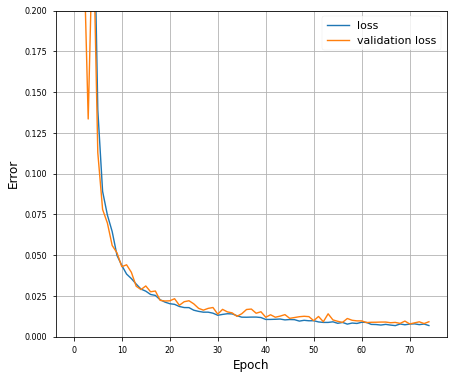

In [ ]:
def plot_loss(history):
    fig = plt.figure(figsize=(7, 6))
    plt.style.use('seaborn-paper')
    plt.rc('font', family='sans-serif')  
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylim([0, 0.2])
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Error', fontsize = 12)
    plt.legend()
    plt.grid(True)
    plt.legend(fontsize = 11)
plot_loss(history)

## Make predictions on test data

### Show the summary of ANN layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 4,802
Trainable params: 4,802
Non-trainable params: 0
_________________________________________________________________


### Give appropriate shape to the test data that is created at the beginning of the notebook

In [ ]:
main = np.zeros((1, N_test, 4))

for i in range(N_test):
    main[0,i,0] = X[i]
    main[0,i,1] = Y[i]
    main[0,i,2] = sigma_X[i]
    main[0,i,3] = sigma_Y[i]

### Plot test data, York's general solution and ANN's prediction on the same figure

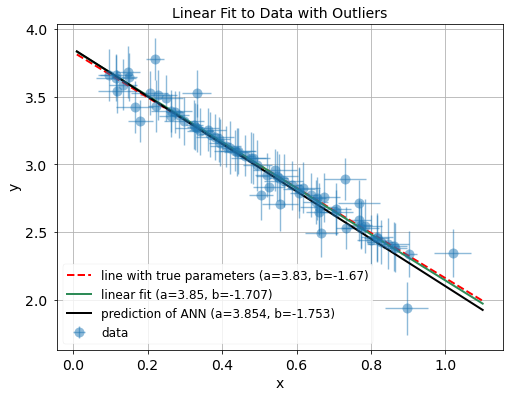

In [ ]:
# Create a figure
fig = plt.figure(figsize=(8, 6))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
#plt.plot(X, Y, 'o', label='data', ms=18.5, alpha=0.2)
plt.errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=10.0, alpha=0.5) # error bars show SD

# Plotting the line with true parameters
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ')'), color = 'red')
# Plotting linear fit
y_plot = a_fit + b_fit*x_plot
plt.plot(x_plot, y_plot, linewidth = 2.0, label=('linear fit (a=' + str(np.round(a_fit, 3)) + 
                                                 ', b=' + str(np.round(b_fit, 3)) + ')'), color = 'seagreen')

a_fit_DNN = model.predict(main)[0,0]
b_fit_DNN = model.predict(main)[0,1]

# Plotting predictions of DNN
y_DNN = a_fit_DNN + b_fit_DNN*x_plot
plt.plot(x_plot, y_DNN, linewidth = 2.0, label = ('prediction of ANN (a=' + str(np.round(a_fit_DNN, 3)) + ', b=' + str(np.round(b_fit_DNN, 3)) + ')'), color = 'black')

# Plot specs
plt.tick_params(labelsize=14)
plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)
plt.title('Linear Fit to Data with Outliers', fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()

## Now, create three different test data from different models and make predictions on them using trained ANNs. We also show predictions obtained by York's general solution.

In [ ]:
# Choose parameters
true_params = np.zeros([3,2])

# True parameters of the models
true_params[0,0] = 3.1
true_params[0,1] = -1.5

true_params[1,0] = 4.6
true_params[1,1] = 3.8

true_params[2,0] = 1.2
true_params[2,1] = -2.7

data_point_nums = [70,45,20] # number of data points

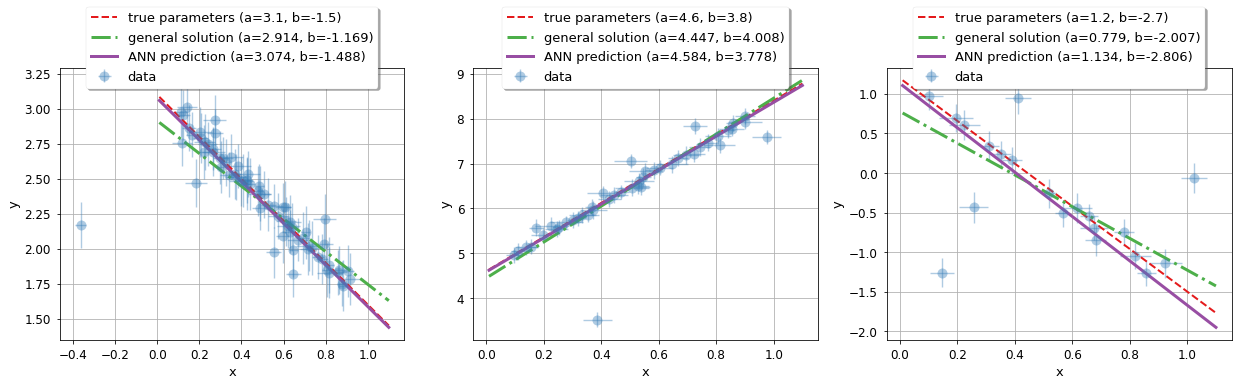

In [ ]:
def triple(a, b, num, N):
  sigma_X = np.random.uniform(0.02, 0.06, N) # sample x coordinate sigmas from uniform distribution
  sigma_Y = np.random.uniform(0.15, 0.20, N) # sample y coordinate sigmas from uniform distribution
  noise_X = np.multiply(distribution.rvs(size=N), sigma_X) # error on x data (normally distributed)
  noise_Y = np.multiply(distribution.rvs(size=N), sigma_Y) # error on y data (normally distributed)
  X = np.linspace(0.1, 0.9, N) + noise_X # observed X points
  Y = b*(X-noise_X) + a + noise_Y # observed Y points

  def linear_fit(b_pred, iter): # start with a prediction of b and number of iterations
    for k in range(iter): 
        w_X = 1/np.power(sigma_X, 2) 
        w_Y = 1/np.power(sigma_Y, 2) 
        W = np.multiply(w_X, w_Y)/(b_pred**2*w_Y + w_X)
        X_bar = np.sum(np.multiply(W, X))/np.sum(W)
        Y_bar = np.sum(np.multiply(W, Y))/np.sum(W)
        U = X - X_bar
        V = Y - Y_bar
        alpha_numerator = 0
        alpha_denominator = 0
        beta_numerator = 0
        beta_denominator = 0
        gamma_numerator = 0
        gamma_denominator = 0
        for i in range(N):
            alpha_numerator = alpha_numerator + W[i]**2*U[i]*V[i]/w_X[i]
            alpha_denominator = alpha_denominator + W[i]**2*U[i]**2/w_X[i]
            beta_numerator = beta_numerator + (W[i]**2*V[i]**2/w_X[i]) - W[i]*U[i]**2
            beta_denominator = beta_denominator + W[i]**2*U[i]**2/w_X[i]
            gamma_numerator = gamma_numerator + W[i]*U[i]*V[i]
            gamma_denominator = gamma_denominator + W[i]**2*U[i]**2/w_X[i]
        alpha = (2*alpha_numerator)/(3*alpha_denominator)
        beta = beta_numerator/(3*beta_denominator)
        gamma = -gamma_numerator/gamma_denominator
        b = []        
        for j in range(3): # there are three roots to be found
            b.append(alpha + 2*np.sqrt(alpha**2 - beta) * 
                     np.cos(1/3*(np.arccos((alpha**3 - 3*alpha*beta/2 + gamma/2)/
                                           (alpha**2 - beta)**(3/2)) + 2*np.pi*j)))
        b_pred = b[2] # root we are looking for is generally the third one (if solution is unusual check that)
        
    a_pred = Y_bar - b_pred*X_bar # calculate the intercept
    return a_pred, b_pred

  data = np.zeros((1, N, 4))
  for i in range(N):
    data[0,i,0] = X[i]
    data[0,i,1] = Y[i]
    data[0,i,2] = sigma_X[i]
    data[0,i,3] = sigma_Y[i]

  x_plot = np.linspace(0.01, 1.1, N)
  y_true_plot = b*x_plot + a

  a_fit, b_fit = linear_fit(5, 4)
  y_plot = a_fit + b_fit*x_plot

  a_ANN = model.predict(data)[0,0]
  b_ANN = model.predict(data)[0,1]
  y_ANN = a_ANN + b_ANN*x_plot

  axs[num].errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=10.0, alpha=0.4, color = '#377eb8') # error bars show SD
  axs[num].plot(x_plot, y_true_plot, '--', linewidth = 2, label=('true parameters (a=' + str(a) +
                                                                       ', b=' + str(b) + ')'), color = '#e41a1c')
  axs[num].plot(x_plot, y_plot, '-.', linewidth = 3, label=('general solution (a=' + str(np.round(a_fit, 3)) + 
                                                               ', b=' + str(np.round(b_fit, 3)) + ')'), color = '#4daf4a')
  axs[num].plot(x_plot, y_ANN, linewidth = 3, label = ('ANN prediction (a=' + str(np.round(a_ANN, 3)) +
                                                          ', b=' + str(np.round(b_ANN, 3)) + ')'), color = '#984ea3')
  
  axs[num].set_xlabel('x', fontsize = 13)
  axs[num].set_ylabel('y', fontsize = 13)

  axs[num].tick_params(labelsize=12)
  axs[num].legend(fontsize = 13, ncol=1, shadow=True, fancybox=True, loc='lower center', bbox_to_anchor=(0.5, 0.9))
  axs[num].grid()
  return()

fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (21,5))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')
for i in range(3):
  triple(true_params[i,0], true_params[i,1], i, data_point_nums[i])

## Calculate parameter variances (Monte Carlo Simulation of Synthetic Data Sets)
Create lots of datasets having the same true parameters but with different $x$, $y$ and error values. Then make predictions for each one. After that, look at the distributions of these predictions.

In [ ]:
def quality_data(N):
    sigma_X = np.random.uniform(0.02, 0.06, N) # sample x coordinate sigmas from uniform distribution
    sigma_Y = np.random.uniform(0.10, 0.15, N) # sample y coordinate sigmas from uniform distribution
    noise_X = np.multiply(distribution.rvs(size = N), sigma_X) # error on x data
    noise_Y = np.multiply(distribution.rvs(size = N), sigma_Y) # error on y data 
 
    # True parameters of the model which will be used to generate data
    a_true = a_fit_DNN
    b_true = b_fit_DNN

    X = np.linspace(0.1, 0.9, N) + noise_X # observed X points
    Y = b_true*(X-noise_X) + a_true + noise_Y
    main = np.zeros((1, N, 4))

    for i in range(N):
        main[0,i,0] = X[i]
        main[0,i,1] = Y[i]
        main[0,i,2] = sigma_X[i]
        main[0,i,3] = sigma_Y[i]
    return main, a_true, b_true

a_qual = []
b_qual = []

for i in range(1000):
    n = np.random.randint(10,100)
    pred = model.predict(quality_data(n)[0])
    a_qual.append(pred[0,0])
    b_qual.append(pred[0,1])
    

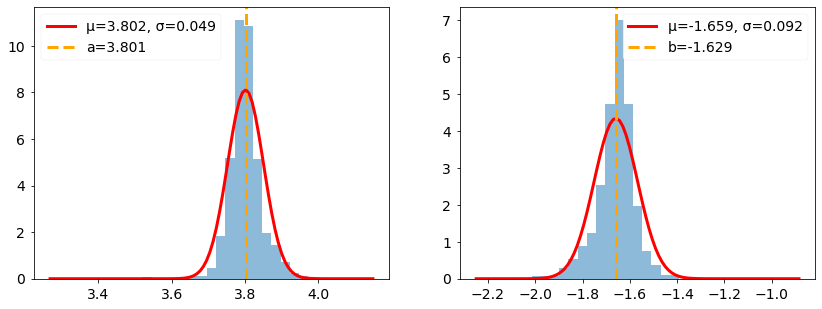

In [ ]:
import scipy
from scipy import stats

fig, axs = plt.subplots(1, 2, figsize=(14,5))

_, bins_a, _ = axs[0].hist(a_qual, 35, density = True, alpha=0.5)
sigma_a = np.std(a_qual)
mu_a = np.mean(a_qual)
a_x_axis_gauss = np.linspace(bins_a[0], bins_a[-1], 100)
best_fit_line_a = scipy.stats.norm.pdf(a_x_axis_gauss, mu_a, sigma_a)
axs[0].plot(a_x_axis_gauss, best_fit_line_a, color = 'red', label = 
         ('\u03BC=' + str(np.round(mu_a, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_a, 3))), linewidth = 3.0)
axs[0].axvline(mu_a, linestyle="--", color="orange", linewidth = 3.0, 
            label = 'a=' + str(np.round(a_fit_DNN, 3)))
axs[0].legend(fontsize = 14)
axs[0].tick_params(labelsize = 14)

_, bins_b, _ = axs[1].hist(b_qual, 35, density=True, alpha=0.5)
sigma_b = np.std(b_qual)
mu_b = np.mean(b_qual)
b_x_axis_gauss = np.linspace(bins_b[0], bins_b[-1], 100)
best_fit_line_b = scipy.stats.norm.pdf(b_x_axis_gauss, mu_b, sigma_b)
axs[1].plot(b_x_axis_gauss, best_fit_line_b, color = 'red', label = 
         ('\u03BC=' + str(np.round(mu_b, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_b, 3))), linewidth = 3.0)
axs[1].axvline(mu_b, linestyle="--", 
            color="orange", linewidth = 3.0, label = 'b=' + str(np.round(b_fit_DNN, 3)))
axs[1].legend(fontsize = 14)
axs[1].tick_params(labelsize=14)

plt.show()